In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/map-charting-student-math-misunderstandings/sample_submission.csv
/kaggle/input/map-charting-student-math-misunderstandings/train.csv
/kaggle/input/map-charting-student-math-misunderstandings/test.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

print("--- Starting Data Preparation ---")

# ==============================================================================
# 1. LOAD DATASET
# ==============================================================================
try:
    df_train = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/train.csv")
    print("Step 1: Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: train.csv not found. Please ensure the file path is correct.")
    # Exit or handle the error appropriately
    exit()

# ==============================================================================
# 2. PREPROCESS AND CREATE TARGET/PROMPT COLUMNS
# ==============================================================================
# Fix the 'NA' string being read as a NaN value by pandas
df_train['Misconception'] = df_train['Misconception'].fillna('NA')
print("Step 2: Corrected 'NA' values in 'Misconception' column.")

# Create the single combined target column
df_train['category_misconception'] = df_train['Category'] + ':' + df_train['Misconception']
print("Step 3: Created 'category_misconception' target column.")

# Define the prompt template
prompt_template = """Analyze the student's reasoning for the following math problem.

### Question:
{QuestionText}

### Student's Answer Choice:
{MC_Answer}

### Student's Explanation:
{StudentExplanation}

### Analysis:"""

# Apply the template to create the 'prompt' column
df_train['prompt'] = df_train.apply(
    lambda row: prompt_template.format(
        QuestionText=row['QuestionText'],
        MC_Answer=row['MC_Answer'],
        StudentExplanation=row['StudentExplanation']
    ),
    axis=1
)
print("Step 4: Created formatted 'prompt' column.")

# ==============================================================================
# 3. ENCODE LABELS
# ==============================================================================
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['category_misconception'])

# We will need these mappings later
id_to_label = {i: label for i, label in enumerate(label_encoder.classes_)}
label_to_id = {label: i for i, label in id_to_label.items()}

print(f"Step 5: Encoded the {len(label_encoder.classes_)} classes into numerical labels.")

# ==============================================================================
# 4. PERFORM MANUAL STRATIFIED SPLIT
# This handles classes with only one member, avoiding the ValueError.
# ==============================================================================
# Get the counts of each class
class_counts = df_train['category_misconception'].value_counts()

# Identify classes with more than 1 member and only 1 member
multi_member_classes = class_counts[class_counts > 1].index
single_member_classes = class_counts[class_counts == 1].index

# Create two separate dataframes
df_multi = df_train[df_train['category_misconception'].isin(multi_member_classes)]
df_single = df_train[df_train['category_misconception'].isin(single_member_classes)]

print(f"\nFound {len(df_single)} samples belonging to classes with only one member.")
print("These will be moved directly to the training set.")

# Perform a stratified split ONLY on the dataframe with multi-member classes
train_multi_df, val_df = train_test_split(
    df_multi,
    test_size=0.1,       # 10% for validation
    random_state=42,     # For reproducibility
    stratify=df_multi['label'] # Stratify on the filtered data
)

# Combine the single-member classes dataframe with the training set
train_df = pd.concat([train_multi_df, df_single])

# Shuffle the final training set to mix the single-member samples
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nStep 6: Data splitting complete.")
print("--- Data Preparation Finished ---\n")

# ==============================================================================
# 5. FINAL VERIFICATION
# ==============================================================================
print(f"Final Training set shape:   {train_df.shape}")
print(f"Final Validation set shape: {val_df.shape}")
print(f"\nAn example from the final training data (prompt):")
print("--------------------------------------------------")
print(train_df['prompt'].iloc[0])
print("--------------------------------------------------")
print(f"Label: {train_df['label'].iloc[0]}")
print(f"Original Label: {train_df['category_misconception'].iloc[0]}")

--- Starting Data Preparation ---
Step 1: Dataset loaded successfully.
Step 2: Corrected 'NA' values in 'Misconception' column.
Step 3: Created 'category_misconception' target column.
Step 4: Created formatted 'prompt' column.
Step 5: Encoded the 65 classes into numerical labels.

Found 5 samples belonging to classes with only one member.
These will be moved directly to the training set.

Step 6: Data splitting complete.
--- Data Preparation Finished ---

Final Training set shape:   (33026, 10)
Final Validation set shape: (3670, 10)

An example from the final training data (prompt):
--------------------------------------------------
Analyze the student's reasoning for the following math problem.

### Question:
Calculate \( \frac{1}{2} \div 6 \)

### Student's Answer Choice:
\( \frac{1}{12} \)

### Student's Explanation:
1/12 because if you times 1/6 x 1/2  it equals 1/12

### Analysis:
--------------------------------------------------
Label: 37
Original Label: True_Correct:NA


In [3]:
!pip install -q -U transformers==4.41.2 peft==0.10.0 bitsandbytes==0.43.1 accelerate==0.30.1 triton==2.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 510.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
import torch
import transformers
import peft
import bitsandbytes
import accelerate
import sys

print("--- Environment Verification ---")
print(f"Python Version: {sys.version}")
print("-" * 30)

# 1. Verify Torch and CUDA
try:
    print(f"PyTorch Version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA Available: {cuda_available}")
    if cuda_available:
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
        print(f"PyTorch CUDA Version: {torch.version.cuda}")
    else:
        print("⚠️ WARNING: CUDA is not available. Training will be extremely slow.")
except Exception as e:
    print(f"❌ Error verifying PyTorch: {e}")

print("-" * 30)

# 2. Verify Transformers
try:
    print(f"Transformers Version: {transformers.__version__}")
except Exception as e:
    print(f"❌ Error verifying Transformers: {e}")

# 3. Verify PEFT
try:
    print(f"PEFT Version: {peft.__version__}")
except Exception as e:
    print(f"❌ Error verifying PEFT: {e}")

# 4. Verify BitsAndBytes
try:
    print(f"BitsAndBytes Version: {bitsandbytes.__version__}")
except Exception as e:
    print(f"❌ Error verifying BitsAndBytes: {e}")

# 5. Verify Accelerate
try:
    print(f"Accelerate Version: {accelerate.__version__}")
except Exception as e:
    print(f"❌ Error verifying Accelerate: {e}")

print("-" * 30)
print("✅ Verification script finished. Check for any warnings or errors above.")

--- Environment Verification ---
Python Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
------------------------------
PyTorch Version: 2.1.2+cu121
CUDA Available: True
GPU Name: Tesla P100-PCIE-16GB
PyTorch CUDA Version: 12.1
------------------------------
Transformers Version: 4.41.2
PEFT Version: 0.10.0
BitsAndBytes Version: 0.43.1
Accelerate Version: 0.30.1
------------------------------
✅ Verification script finished. Check for any warnings or errors above.


In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType

# Load the base model name
model_name = "Qwen/Qwen2.5-Math-1.5B"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    
# Configure quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Load the model with a sequence classification head
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    num_labels=len(id_to_label), # Pass the number of classes
    id2label=id_to_label,       # Pass the mappings
    label2id=label_to_id,
    device_map="auto"
)

# The model's classification head needs a pad token ID
model.config.pad_token_id = tokenizer.pad_token_id

# Configure LoRA for the classification model
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS, # IMPORTANT: Change task type to Sequence Classification
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    modules_to_save=["score"],
)

model = get_peft_model(model, lora_config)

print("✅ Model loaded as Sequence Classifier and QLoRA configured.")
model.print_trainable_parameters()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-Math-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded as Sequence Classifier and QLoRA configured.
trainable params: 4,457,984 || all params: 1,548,272,128 || trainable%: 0.2879328458724279


In [6]:
import torch
import numpy as np
from transformers import TrainingArguments, Trainer
from sklearn.utils.class_weight import compute_class_weight

# ==============================================================================
# 1. DEFINE TRAINING ARGUMENTS
# ==============================================================================
# These arguments control the entire training process.
training_args = TrainingArguments(
    output_dir="qwen2_5-math-finetuned", # Directory to save the model
    num_train_epochs=3,                  # Number of times to train on the whole dataset
    per_device_train_batch_size=2,       # Batch size for training
    per_device_eval_batch_size=8,        # Batch size for evaluation
    gradient_accumulation_steps=4,       # Accumulate gradients to simulate a larger batch size
    optim="paged_adamw_8bit",            # Memory-efficient optimizer
    learning_rate=2e-4,                  # The learning rate
    lr_scheduler_type="cosine",          # Learning rate scheduler
    warmup_ratio=0.03,                   # Warmup steps for the scheduler
    logging_steps=25,                    # How often to log training progress
    evaluation_strategy="steps",         # Evaluate during training
    eval_steps=100,                      # Evaluate every 100 steps
    save_strategy="steps",               # Save model checkpoints during training
    save_steps=100,                      # Save every 100 steps
    load_best_model_at_end=True,         # Load the best model found during training at the end
    metric_for_best_model="map_at_3",    # The metric to determine the "best" model
    greater_is_better=True,              # For MAP@3, a higher score is better
    fp16=False,                           # Use 16-bit precision for training for speed and memory
    report_to="none",                    # Disable reporting to services like WandB
)


# ==============================================================================
# 2. CALCULATE CLASS WEIGHTS
# ==============================================================================
# This is crucial for telling the model to pay more attention to rare classes.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label'].to_numpy()
)
# Convert to a PyTorch tensor and move to the GPU
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float16).to(model.device)


# ==============================================================================
# 3. CREATE METRICS FUNCTION (MAP@3)
# ==============================================================================
def compute_metrics(eval_pred):
    """Calculates Mean Average Precision @ 3."""
    predictions, labels = eval_pred
    # The predictions are logits, so we get the top 3 class indices
    top_3_preds = np.argsort(predictions, axis=1)[:, -3:]

    ap_scores = []
    for i, label in enumerate(labels):
        if label in top_3_preds[i]:
            # Find the rank of the true label in the top 3 predictions
            rank = np.where(np.flip(top_3_preds[i]) == label)[0][0] + 1
            ap_scores.append(1.0 / rank)
        else:
            ap_scores.append(0.0)

    return {"map_at_3": np.mean(ap_scores)}


# ==============================================================================
# 4. CREATE CUSTOM TRAINER FOR WEIGHTED LOSS
# ==============================================================================
class CustomTrainer(Trainer):
    """Custom Trainer to handle class imbalance with a weighted loss function."""
    def compute_loss(self, model, inputs, return_outputs=False):
        # The 'labels' are the integer class IDs we created
        labels = inputs.pop("labels")
        # Get model outputs
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Define the loss function with our calculated class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        # Calculate the loss
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

print("✅ Custom Trainer and helper functions are defined.")

2025-08-25 06:44:35.103153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756104275.298257      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756104275.363618      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Custom Trainer and helper functions are defined.


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Token Length Statistics:
count    33026.000000
mean        89.577030
std         20.613219
min         46.000000
25%         74.000000
50%         88.000000
75%        103.000000
max        340.000000
dtype: float64


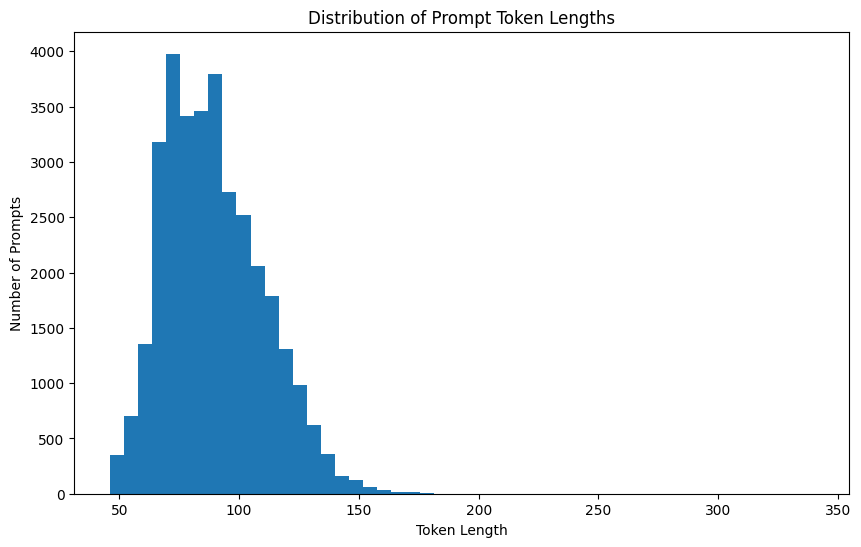

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the token length for each prompt in your training data
token_lengths = [len(tokenizer.encode(text)) for text in train_df['prompt']]

# Get descriptive statistics
series_lengths = pd.Series(token_lengths)
print("Token Length Statistics:")
print(series_lengths.describe())

# Plot a histogram to visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50)
plt.title('Distribution of Prompt Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Number of Prompts')
plt.show()

In [8]:
import json

# Create a dictionary to hold both of your label mappings
mappings_to_save = {
    'id_to_label': id_to_label,
    'label_to_id': label_to_id
}

# Save this dictionary to a file named 'label_mappings.json'
with open('label_mappings.json', 'w') as f:
    json.dump(mappings_to_save, f)

print("✅ Label mappings have been saved to label_mappings.json")

✅ Label mappings have been saved to label_mappings.json


In [9]:
# First, we need to create PyTorch Dataset objects.
# The Trainer API works best with this format.
class MathDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        # We need to find the max_length for padding
        # You can also set a fixed number like 512
        self.max_length = 128 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Tokenize the prompt text
        encoding = self.tokenizer(
            row['prompt'],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # The tokenizer output is a dictionary. Squeeze to remove batch dimension.
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(row['label'], dtype=torch.long)
        }

# Create the dataset objects
train_dataset = MathDataset(train_df, tokenizer)
val_dataset = MathDataset(val_df, tokenizer)

# Instantiate the CustomTrainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Start the training process!
print("🚀 Starting model training...")
trainer.train()

# Save the final, best-performing model adapter
print("✅ Training finished. Saving the best model...")
trainer.save_model("qwen-finetuned-best-checkpoint")

print("All done! 🎉")

🚀 Starting model training...


Step,Training Loss,Validation Loss,Map At 3
100,3.148600,5.035156,0.450000
200,2.896800,4.351562,0.514260
300,2.046700,4.570312,0.592961
400,2.697100,2.839844,0.630291
500,1.573500,2.648438,0.775840
600,1.849500,2.312500,0.789237
700,1.345600,1.885742,0.835922
800,1.388000,2.302734,0.826794
900,0.860900,1.796875,0.854087
1000,1.075800,1.663086,0.866667


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in ver

✅ Training finished. Saving the best model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


All done! 🎉
